In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qepy.calculator import QEpyCalculator 
from qepy.io import QEInput
from qepy.driver import Driver
from dftpy.visualize import view
from ase.build import bulk
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal
from ase.build import make_supercell

# from ase.visualize import view
import pickle

/home/vr371/.local/lib/python3.8/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


In [2]:
try:
    from mpi4py import MPI
    comm=MPI.COMM_WORLD
except:
    comm=None

In [ ]:
qe_options = {
        '&control': {
            'calculation': "'scf'",
            'prefix': "'si'",
            'pseudo_dir': "'/home/vr371/PP/ofpp/EAC/upf/blps'",
            'restart_mode': "'from_scratch'"},
        '&system': {
            'ibrav' : 1,
            'nat': 98,
            'degauss': 0.005,
            'ecutwfc': 60,
            'occupations': "'smearing'"},
        'atomic_species': ['Si  28.08 si.lda.upf'],
        'cell_parameters angstrom': ['5.43    0.0000000000000000    0.0000000000000003',
                                     '0.0000000000000009    5.43    0.0000000000000003',
                                     '0.0000000000000000    0.0000000000000000    5.43'],
         'k_points automatic': ['20 20 20 1 1 1']}

# KS DFT
l = np.linspace(0.8, 1.4, 30)
Volume = []
for i in np.arange(0, len(l), 1):
        n = int(i)
        X = l[n]
        si_Btin = crystal('Si',[(0,0,0)],spacegroup=141,cellpar = [4.81,4.81,2.65, 90,90,90])
        si_fcc = bulk('Si', 'fcc', a=3.405, cubic=True)
        Btin_supercell = make_supercell(si_Btin, [[2, 0, 0], [0, 2, 0], [0, 0, 3]])
        fcc_supercell = make_supercell(si_fcc, [[3, 0, 0], [0, 3, 0], [0, 0, 2]])
        combined_cell = Btin_supercell.copy()
        fcc_supercell.translate([0, 0, combined_cell.cell[2, 2]])
        combined_cell.extend(fcc_supercell)
        y_coord = 8.512
        tolerance = 0.1
        ny = np.where(np.abs(combined_cell.positions[:,1] - y_coord) < tolerance)[0]
        nx = np.where(np.abs(combined_cell.positions[:,0] - y_coord) < tolerance)[0]
        supercell = combined_cell[np.logical_not(np.in1d(np.arange(len(combined_cell)), np.hstack((ny,nx))))]
        supercell.set_cell([Btin_supercell.get_cell()[0][0], Btin_supercell.get_cell()[1][1], Btin_supercell.get_cell()[2][2]+fcc_supercell.get_cell()[2][2]])
        si = supercell
        cell = si.get_cell()
        si.set_cell(cell * X, scale_atoms=True)
        Volume.append(si.get_volume())
        qe_options = QEInput.update_atoms(si, qe_options = qe_options,  extrapolation=False)
        QEInput().write_qe_input("/home/vr371/cWT-KEDF/Interphases/DATA/Btin_fcc/DATA2/Si"+str(n)+".in", qe_options=qe_options)
        driver = Driver('/home/vr371/cWT-KEDF/Interphases/DATA/Btin_fcc/DATA2/Si'+str(n)+'.in', comm=comm, logfile='/home/vr371/cWT-KEDF/Interphases/DATA/Btin_fcc/DATA2/Si'+str(n)+'.out')
        driver.scf()
        driver.calc_energy()
        rho = driver.data2field(driver.get_density())
        ions = driver.get_dftpy_ions()
        rho.write('/home/vr371/cWT-KEDF/Interphases/DATA/Btin_fcc/DATA2/rho0'+str(i)+'.xsf', ions=ions)
        driver.stop()

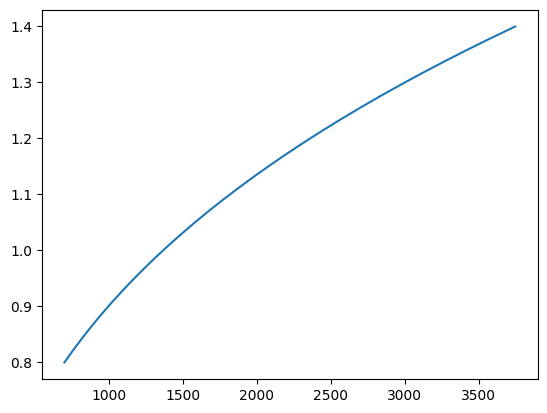

In [37]:
plt.plot(np.asarray(Volume), l)

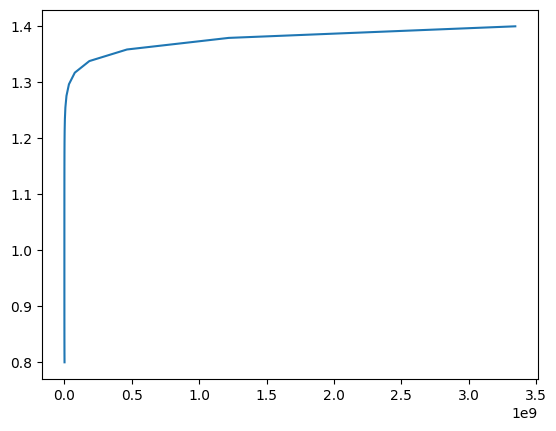

In [35]:
plt.plot(np.asarray(Volume), l)

In [ ]:
KS_TE = []
for i in np.arange(0,30,1):
    with open('/home/vr371/cWT-KEDF/Interphases/DATA/Btin_fcc/Si'+str(i)+'.out') as D:
        k = [match for match in D if "Total energy" in match]
    KS_te = str(k).split()[6]
    KS_TE.append(float(KS_te)) 